### Загрузка необходимых библиотек

In [0]:
"""
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from fastai.text import *
import os
from tqdm import tqdm_notebook
"""
#Для использования Google Drive

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image


In [283]:
"""
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = '/content/gdrive/My Drive'
"""
#Для использования Google Drive

Mounted at /content/gdrive


In [0]:
#ROOT_PATH = Path('/content/gdrive/My Drive/lesson3')
#Для использования Google Drive

In [0]:
import warnings
warnings.filterwarnings('ignore')

## Регрессия

In [286]:
from IPython.display import Image

Image("Регрессия.gif", width=750, height=750)

### Постановка задачи

В крупном магазине продуктовой сети появилась необходимость автоматического прогнозирования продаж товаров с целью более эффективного управления складскими запасами. Для этого нами были получены тестовые данные на 1 товар одного магазина сети за 2014 - 2018 гг. По информации от руководства сети, на продажи предоставленного товара не влияют продажи других товаров в магазине. Также известно, что товар все это время был в наличии в магазине.

In [287]:
Image("shop.jpg", width=750, height=750)

### Загрузка данных

In [288]:
df=pd.read_csv('data_for_regression.csv', sep=';')
#df=pd.read_csv(ROOT_PATH/'data_for_regression.csv', sep=';')
#Для использования Google Drive
df.head()

,date,price,T,sales
0,2014-01-01,126.9,-27,87.110569
1,2014-01-02,126.9,-25,117.233120
2,2014-01-03,126.9,-20,109.978085
3,2014-01-04,126.9,-21,114.134202
4,2014-01-05,115.9,-24,125.839838


In [0]:
# Преобразуем поле date в тип дата
df['date']=pd.to_datetime(df['date'], format='%Y-%m-%d')

In [290]:
df.columns

Index(['date', 'price', 'T', 'sales'], dtype='object')

### Данные

'date' - Дата;
'price' - цена, руб;
'T' - температура;
'sales' - продажи, шт.

In [291]:
# Объем данных
df.shape

(1826, 4)

In [292]:
# Статистика
df.describe()

,price,T,sales
count,1826.000000,1826.000000,1826.000000
mean,109.736254,0.841731,207.388282
std,24.062636,16.843083,95.151028
min,69.900000,-34.000000,56.443239
25%,87.900000,-15.000000,138.657888
50%,105.900000,1.000000,185.898634
75%,124.900000,16.000000,253.047532
max,157.900000,32.000000,860.714197


Text(0, 0.5, 'Продажи, шт')

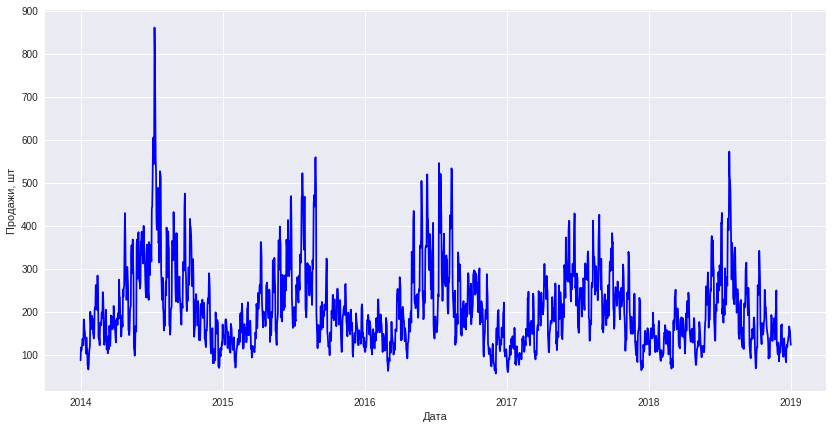

In [293]:
# График продаж за 2014 - 2018 гг.
plt.figure(figsize=(14,7))
plt.plot(df['date'], df['sales'], 'b')
plt.xlabel('Дата')
plt.ylabel('Продажи, шт')

Text(0, 0.5, 'Продажи, шт')

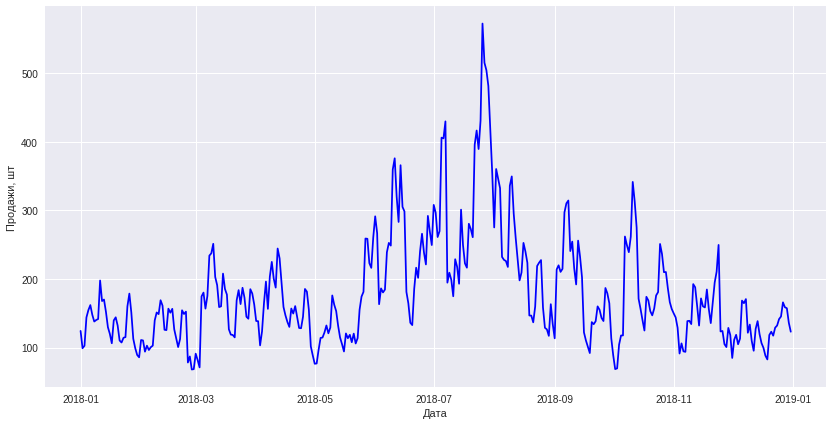

In [294]:
# График продаж за 2018 г.
plt.figure(figsize=(14,7))
plt.plot(df[df['date']>='2018-01-01']['date'], df[df['date']>='2018-01-01']['sales'], 'b')
plt.xlabel('Дата')
plt.ylabel('Продажи, шт')

### Генерация признаков даты

In [0]:
df['dw']=pd.DatetimeIndex(df.date).weekday+1
df['month']=pd.DatetimeIndex(df.date).month
df['year']=pd.DatetimeIndex(df.date).year

### Целевая переменная

(array([183., 533., 425., 319., 165.,  94.,  53.,  24.,  18.,   8.,   1.,   1.,   0.,   1.,   1.]),
 array([ 56.443239, 110.061303, 163.679367, 217.297431, 270.915495, 324.533558, 378.151622, 431.769686, 485.38775 ,
        539.005814, 592.623878, 646.241942, 699.860005, 753.478069, 807.096133, 860.714197]),
 <a list of 15 Patch objects>)

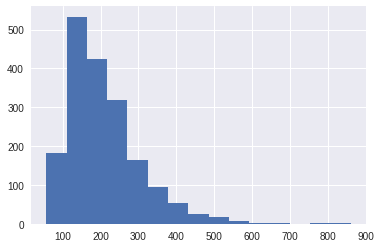

In [296]:
plt.hist(df['sales'], bins=15)

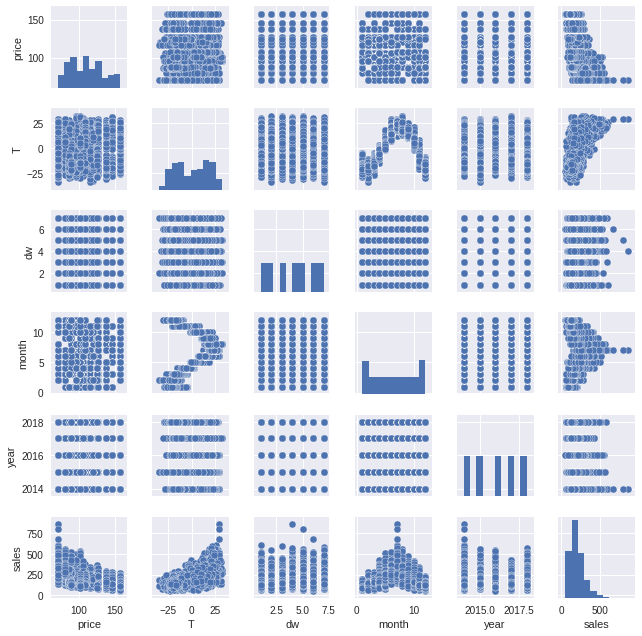

In [297]:
# Матрица графиков рассеяния геопризнаков и категории продаж
col=['price', 'T', 'dw', 'month', 'year', 'sales']
sns.pairplot(df[col], size=1.5)

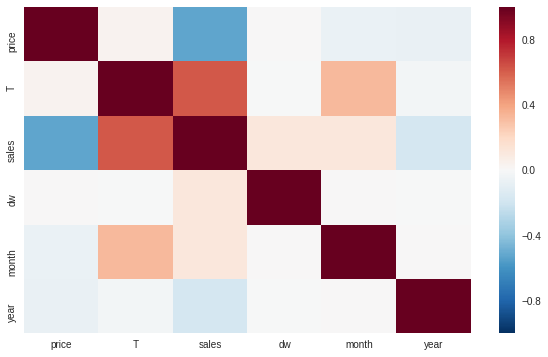

In [298]:
# Корреляционная матрица
data_corr=df.corr()

plt.figure(figsize = (10,6))
sns.heatmap(data_corr)

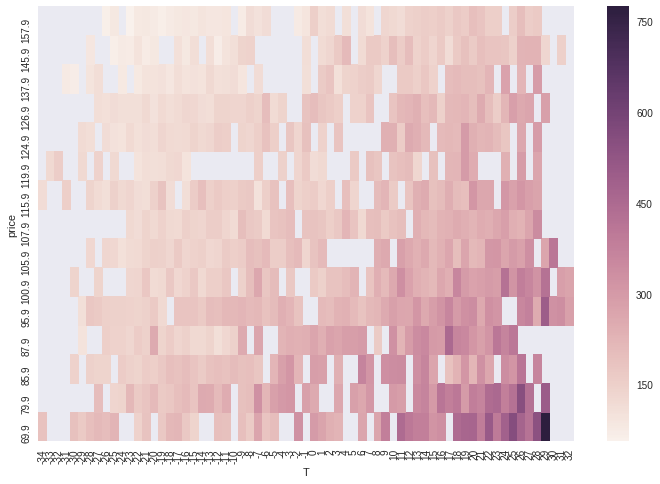

In [299]:
# Зависимость от долготы и широты
df_copy=df.copy()
# df_copy['longitude_round']=np.round(df_copy['longitude'], 0)
# df_copy['latitude_round']=np.round(df_copy['latitude'], 0)

plt.figure(figsize = (12,8))
sns.heatmap(df_copy.pivot_table('sales', index=['price'], 
                            columns=['T'],  aggfunc='mean').copy()
                                    .sort_values(by='price', ascending=False))

### Подготовка данных для обучения модели

In [0]:
# Разделение признаков и целевой переменной. Удаление неинформативных признаков.

X=df[[
    'price', 
    'T', 
    'dw', 
    'month', 
    'year'
    ]]

Y=df['sales']


### Разделение данных на обучающую и тестовую выборку

In [0]:

x_lim=int(len(X)*0.80)

X_train=X[0:x_lim].copy()
Y_train=Y[0:x_lim].copy()
X_test=X[x_lim+1:].copy()
Y_test=Y[x_lim+1:].copy()

### Типы данных

In [302]:
# Группировка по дням недели
df.groupby(by='dw').mean()[['sales']]

,sales
dw,
1,199.066736
2,179.044581
3,177.761544
4,237.697880
5,232.804503
6,221.693851
7,203.540286


In [0]:
# Разделение данных на вещественные и категориальные


X_train_v=X_train[['price', 'T', 'year']]
X_train_k=X_train[['dw', 'month']]

X_test_v=X_test[['price', 'T', 'year']]
X_test_k=X_test[['dw', 'month']]

In [304]:
# Обработка вещественных данных

from sklearn.preprocessing import StandardScaler

ss=StandardScaler()

X_train_v=ss.fit_transform(X_train_v)
X_test_v=ss.transform(X_test_v)

print('Минимум и максимум обучающего набора: ', X_train_v.min(), X_train_v.max())
print('Минимум и максимум тестового набора: ', X_test_v.min(), X_test_v.max())

Минимум и максимум обучающего набора:  -2.0773119583706046 1.997624828871071
Минимум и максимум тестового набора:  -1.7827779627969456 2.2379076059289975


In [0]:
# Обработка категориальных данных

from sklearn.preprocessing import OneHotEncoder

one=OneHotEncoder(sparse=False)
one.fit(X_train_k)
X_train_k=one.transform(X_train_k)
X_test_k=one.transform(X_test_k)

In [306]:
# Новое представление данных для признака "День недели"

X_train_k[0][0:7]

array([0., 0., 1., 0., 0., 0., 0.])

In [0]:
# Объединяем вещественные и категориальные данные

X_train_all=np.hstack((X_train_v, X_train_k))
X_test_all=np.hstack((X_test_v, X_test_k))

In [308]:
X_train_all.shape

(1460, 22)

### Базовое решение

В качестве базового решения используем методику ручного прогнозирования, используемого в сети: средние продажи за последние 30 дней.

In [0]:
Y_mean=Y_test.rolling(window=30).mean()

In [310]:
from sklearn.metrics import mean_absolute_error

print('Среднее абсолютное отклонение: ', np.round(mean_absolute_error(Y_test[30:], Y_mean[30:]), 2))
print('Среднее значение продаж: ', np.round(Y_test[30:].mean(), 2))

Среднее абсолютное отклонение:  49.28
Среднее значение продаж:  184.07


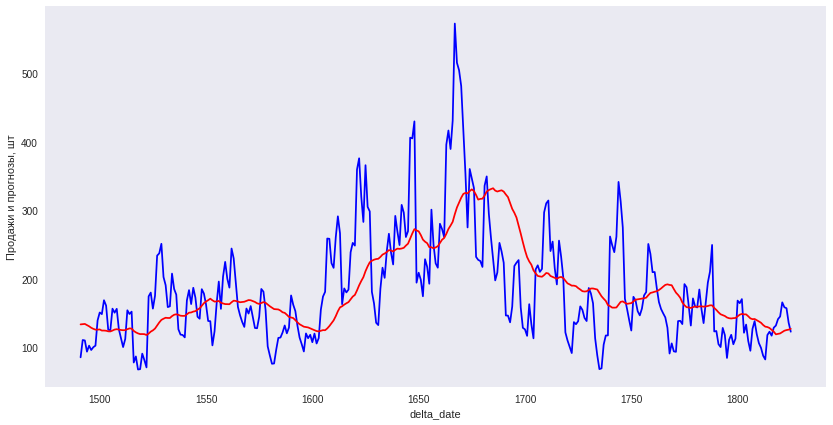

In [311]:
# Графики продаж и прогнозов

plt.figure(figsize=(14,7))
plt.plot(Y_test[30:], 'b')
plt.plot(Y_mean[30:], 'r')
plt.xlabel('delta_date')
plt.ylabel('Продажи и прогнозы, шт')
plt.grid()

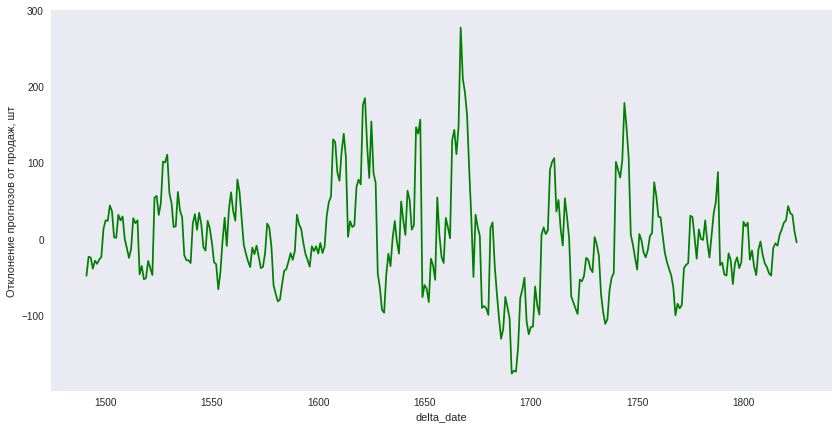

In [312]:
# Отклонение прогноза от факта

plt.figure(figsize=(14,7))
plt.plot(Y_test[30:] - Y_mean[30:], 'g')
plt.xlabel('delta_date')
plt.ylabel('Отклонение прогнозов от продаж, шт')
plt.grid()

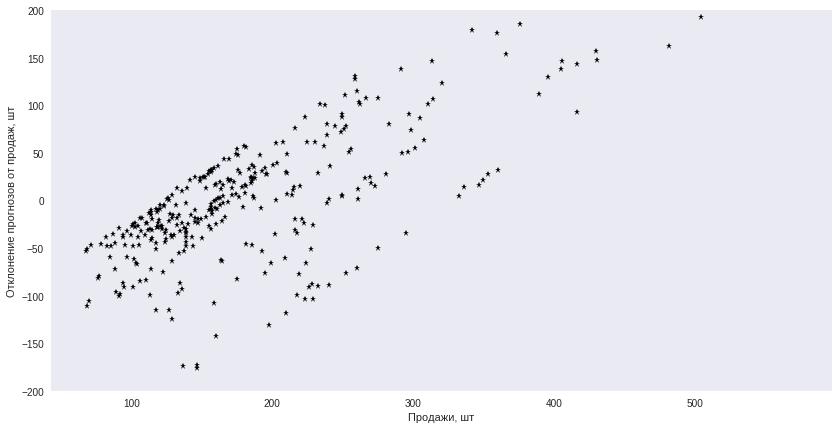

In [313]:
# График остатков

plt.figure(figsize=(14,7))
plt.plot(Y_test[30:], Y_test[30:] - Y_mean[30:], 'k*')
plt.xlabel('Продажи, шт')
plt.ylabel('Отклонение прогнозов от продаж, шт')
plt.ylim([-200, 200])
plt.grid()

### Линейная регрессия для одного признака

In [314]:
Image("linear_regression.jpg", width=500, height=500)

### Линейная регрессия для n - признаков

In [315]:
Image("Линейная регрессия для двух признаков.png", width=500, height=500)

In [316]:
from sklearn.linear_model import LinearRegression

lr=LinearRegression()
lr.fit(X_train_all, Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [317]:

Pred_lr_train=lr.predict(X_train_all)
Pred_lr_test=lr.predict(X_test_all)
print('Среднее абсолютное отклонение: ', np.round(mean_absolute_error(Y_train[30:], Pred_lr_train[30:]), 2))
print('Среднее абсолютное отклонение: ', np.round(mean_absolute_error(Y_test[30:], Pred_lr_test[30:]), 2))

Среднее абсолютное отклонение:  28.18
Среднее абсолютное отклонение:  24.94


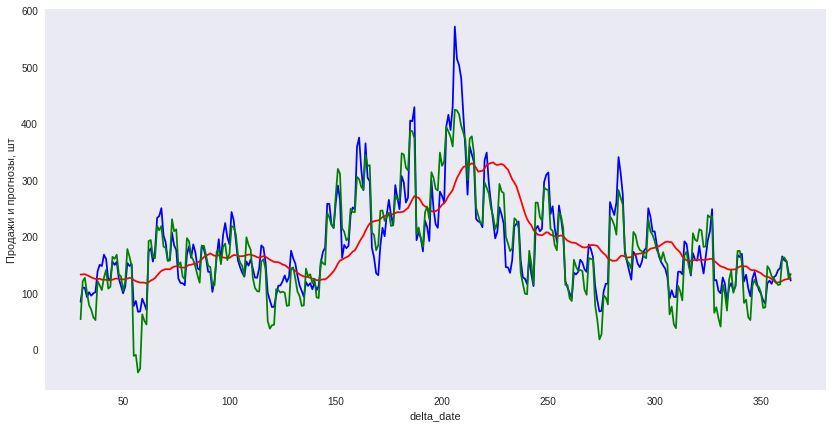

In [318]:
plt.figure(figsize=(14,7))
x=range(len(Y_test))
plt.plot(x[30:], Y_test[30:], 'b')
plt.plot(x[30:], Y_mean[30:], 'r')
plt.plot(x[30:], Pred_lr_test[30:], 'g')
plt.xlabel('delta_date')
plt.ylabel('Продажи и прогнозы, шт')
plt.grid()

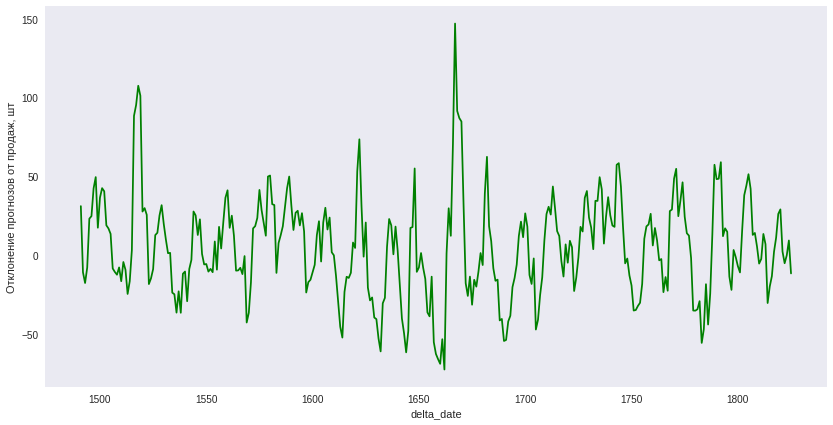

In [319]:
plt.figure(figsize=(14,7))
plt.plot(Y_test[30:] - Pred_lr_test[30:], 'g')
plt.xlabel('delta_date')
plt.ylabel('Отклонение прогнозов от продаж, шт')
plt.grid()

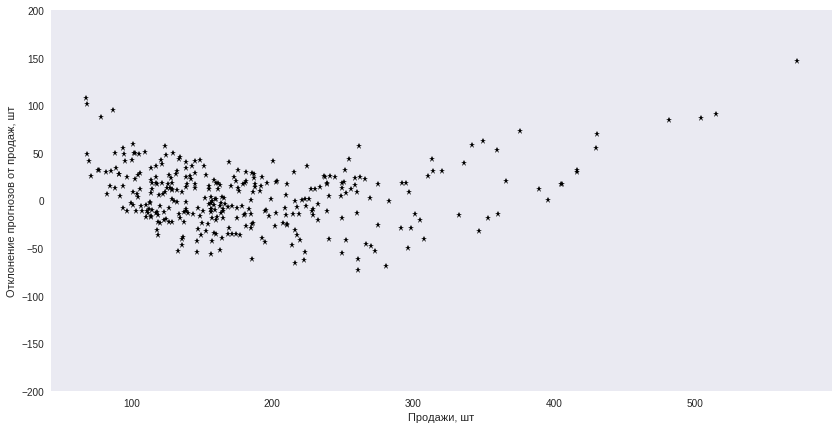

In [320]:
# График остатков

plt.figure(figsize=(14,7))
plt.plot(Y_test[30:], Y_test[30:] - Pred_lr_test[30:], 'k*')
plt.ylim([-200, 200])
plt.xlabel('Продажи, шт')
plt.ylabel('Отклонение прогнозов от продаж, шт')
plt.grid()

### Зачем нужен член смещения a

In [321]:
from IPython.display import display

i1=Image("Регрессия без смещения.jpg", width=500, height=500)
i2=Image("Регрессия со смещением.jpg", width=500, height=500)

display(i1, i2)

In [0]:
a_train = np.zeros((X_train_all.shape[0], 1)) + 1
a_test = np.zeros((X_test_all.shape[0], 1)) + 1

In [0]:
X_train_all=np.hstack((X_train_all, a_train))
X_test_all=np.hstack((X_test_all, a_test))

In [324]:
X_train_all.shape

(1460, 23)

## "НЕ"линейная регресссия

In [325]:
Image("Полиномиальная регрессия.gif", width=600, height=600)

In [326]:
Image("виды регрессии.jpg", width=600, height=600)

In [327]:
Image("Линеаризация.png", width=750, height=750)

In [328]:
Image("Полиномиальная регрессия2.gif", width=600, height=600)

## Поиск оптимальной линии регрессии (градиентный спуск)

In [329]:
Image("Регрессия.gif", width=750, height=750)

#### Функция потерь (среднеквадратичное отклонение в матричном виде):

### min || bx -  y ||²

In [330]:
Image("Градиентный спуск.gif", width=750, height=750)

In [331]:
Image("Градиентный спуск2.gif", width=750, height=750)

In [332]:
Image("Градиентный спуск 3.jpg", width=750, height=750)

### Что такое градиент?

In [333]:
Image("Градиент формула.jpg", width=750, height=750)

### Регуляризация

In [334]:
i1=Image("reg1.png", width=250, height=250)
i2=Image("reg2.png", width=250, height=250)
i3=Image("reg3.png", width=250, height=250)

display(i1, i2, i3)

In [335]:
# Гребневая регрессия (L2 - регуляризация)

from sklearn.linear_model  import Ridge

lr_ridge=Ridge(alpha=10)
lr_ridge.fit(X_train_all, Y_train)

Ridge(alpha=10, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

### min ( || bx — y ||² + z|| b ||² )

In [336]:
Pred_lr_ridge_train=lr_ridge.predict(X_train_all)
Pred_lr_ridge_test=lr_ridge.predict(X_test_all)
print('Среднее абсолютное отклонение: ', np.round(mean_absolute_error(Y_train[30:], Pred_lr_ridge_train[30:]), 2))
print('Среднее абсолютное отклонение: ', np.round(mean_absolute_error(Y_test[30:], Pred_lr_ridge_test[30:]), 2))

Среднее абсолютное отклонение:  28.33
Среднее абсолютное отклонение:  24.65


In [337]:
# Лассо регрессия (L1 - регуляризация)

from sklearn.linear_model  import Lasso

lr_lasso=Lasso(alpha=0.15)
lr_lasso.fit(X_train_all, Y_train)

Lasso(alpha=0.15, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

### min || bx — y ||² + z|| b ||

In [338]:
Pred_lr_lasso_train=lr_lasso.predict(X_train_all)
Pred_lr_lasso_test=lr_lasso.predict(X_test_all)
print('Среднее абсолютное отклонение: ', np.round(mean_absolute_error(Y_train[30:], Pred_lr_lasso_train[30:]), 2))
print('Среднее абсолютное отклонение: ', np.round(mean_absolute_error(Y_test[30:], Pred_lr_lasso_test[30:]), 2))

Среднее абсолютное отклонение:  28.25
Среднее абсолютное отклонение:  24.73


In [339]:
# Эластичная регрессия (L1 и L2 - регуляризация)

from sklearn.linear_model  import ElasticNet

lr_elastic=ElasticNet(alpha=0.05, l1_ratio=0.005)
lr_elastic.fit(X_train_all, Y_train)

ElasticNet(alpha=0.05, copy_X=True, fit_intercept=True, l1_ratio=0.005,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

### min || bx — y ||² + z_1|| b || + z_2|| b ||²

In [340]:

Pred_lr_elastic_train=lr_elastic.predict(X_train_all)
Pred_lr_elastic_test=lr_elastic.predict(X_test_all)
print('Среднее абсолютное отклонение: ', np.round(mean_absolute_error(Y_train[30:], Pred_lr_elastic_train[30:]), 2))
print('Среднее абсолютное отклонение: ', np.round(mean_absolute_error(Y_test[30:], Pred_lr_elastic_test[30:]), 2))


Среднее абсолютное отклонение:  29.08
Среднее абсолютное отклонение:  23.7


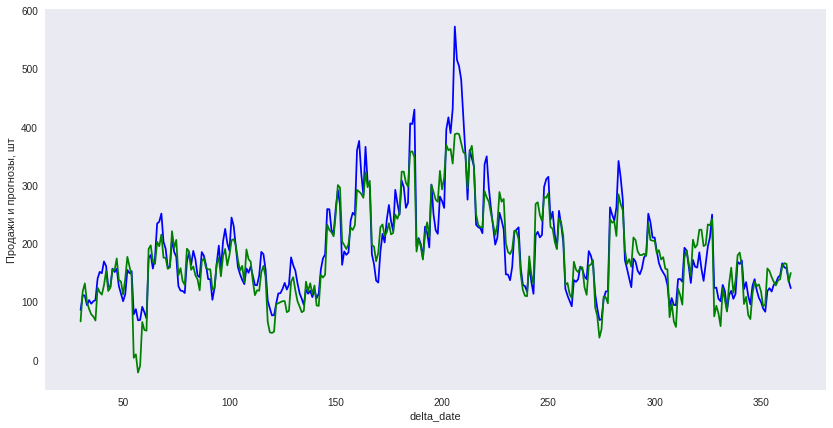

In [341]:
plt.figure(figsize=(14,7))
x=range(len(Y_test))
plt.plot(x[30:], Y_test[30:], 'b')
plt.plot(x[30:], Pred_lr_elastic_test[30:], 'g')
plt.xlabel('delta_date')
plt.ylabel('Продажи и прогнозы, шт')
plt.grid()

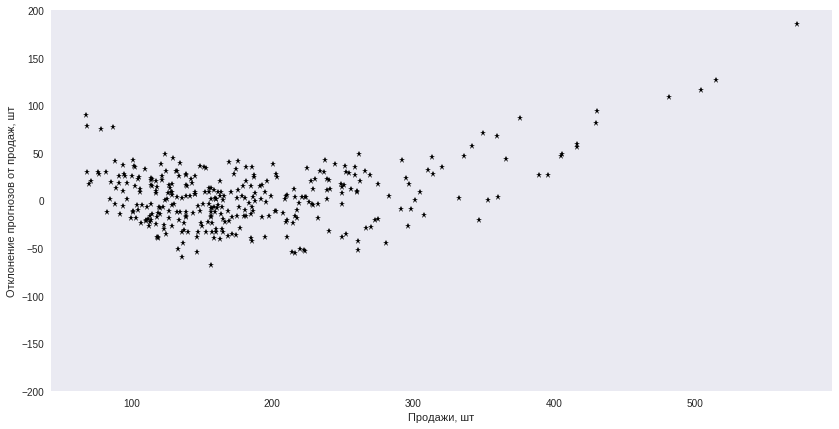

In [342]:
# График остатков

plt.figure(figsize=(14,7))
plt.plot(Y_test[30:], Y_test[30:] - Pred_lr_elastic_test[30:], 'k*')
plt.ylim([-200, 200])
plt.xlabel('Продажи, шт')
plt.ylabel('Отклонение прогнозов от продаж, шт')
plt.grid()

## feature engineering

In [0]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree = 2)
poly.fit(X_train_all)
X_train_all_poly = poly.transform(X_train_all)
X_test_all_poly = poly.transform(X_test_all)

In [344]:
X_train_all_poly.shape

(1460, 300)

Регрессия до полиномиального преобразования (для двух признаков)

Y = b_1*X_1 + b_2*X_2  + a

Регрессия после полиномиального преобразования (для двух признаков)

Y = b_1*X_1 + b_2*X_2 + b_3*X_1²  + b_4*X_2²  + b_5*X_1*X_2  + a

In [345]:
lr_elastic=ElasticNet(alpha=0.05, l1_ratio=0.005)
lr_elastic.fit(X_train_all_poly, Y_train)
Pred_lr_elastic_train=lr_elastic.predict(X_train_all_poly)
Pred_lr_elastic_test=lr_elastic.predict(X_test_all_poly)
print('Среднее абсолютное отклонение: ', np.round(mean_absolute_error(Y_train[30:], Pred_lr_elastic_train[30:]), 2))
print('Среднее абсолютное отклонение: ', np.round(mean_absolute_error(Y_test[30:], Pred_lr_elastic_test[30:]), 2))


Среднее абсолютное отклонение:  22.65
Среднее абсолютное отклонение:  22.0


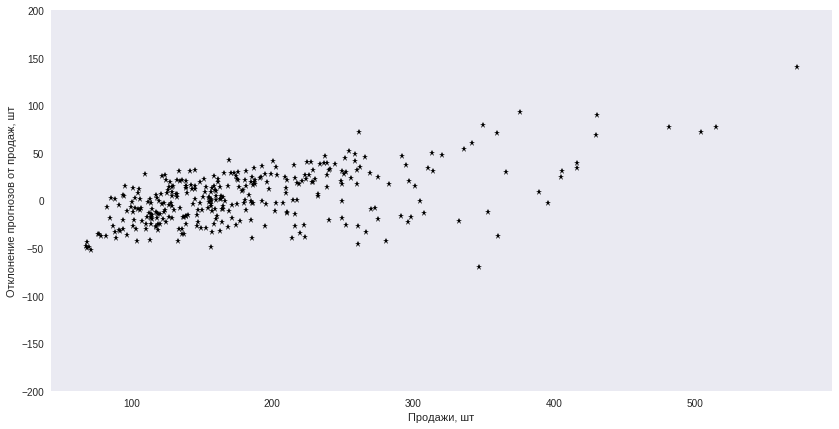

In [346]:
# График остатков

plt.figure(figsize=(14,7))
plt.plot(Y_test[30:], Y_test[30:] - Pred_lr_elastic_test[30:], 'k*')
plt.ylim([-200, 200])
plt.xlabel('Продажи, шт')
plt.ylabel('Отклонение прогнозов от продаж, шт')
plt.grid()

## Статистические методы прогнозирования временных рядов

Text(0, 0.5, 'Продажи, шт')

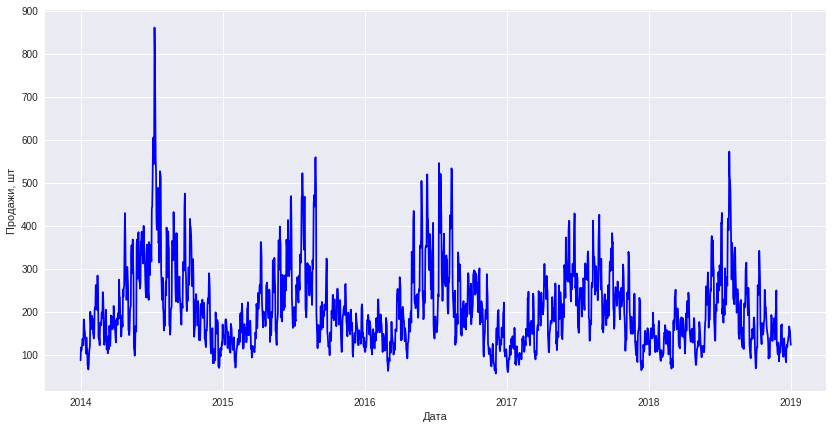

In [347]:
# График продаж за 2014 - 2018 гг.
plt.figure(figsize=(14,7))
plt.plot(df['date'], df['sales'], 'b')
plt.xlabel('Дата')
plt.ylabel('Продажи, шт')

Text(0, 0.5, 'Продажи со смещением на delta, шт')

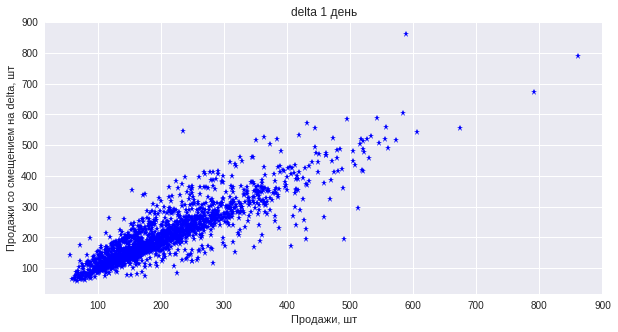

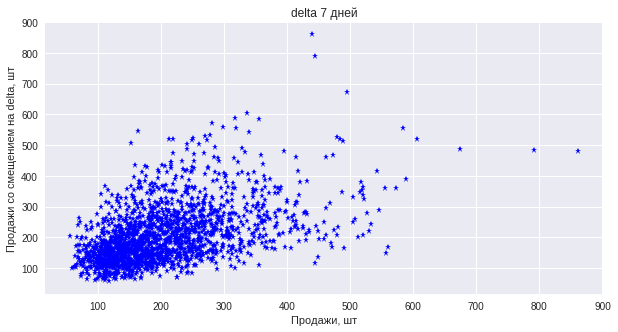

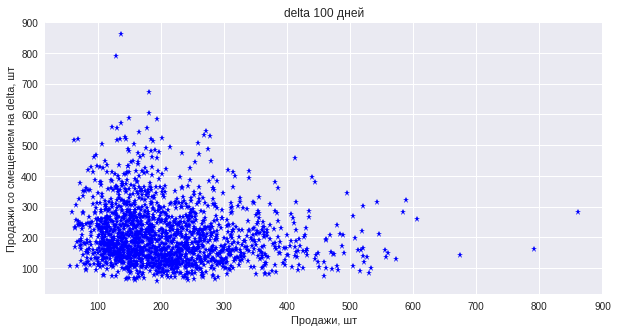

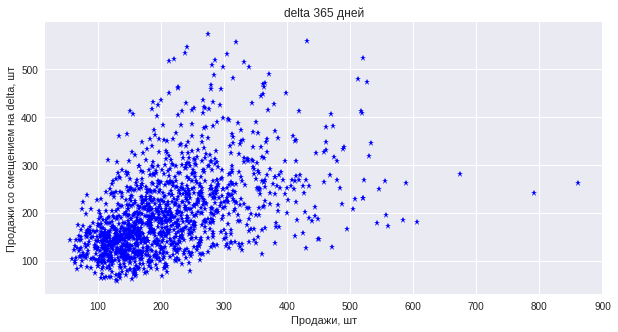

In [348]:
# График продаж за 2014 - 2018 гг.
delta = 1
plt.figure(figsize=(10,5))
plt.plot(df.loc[0:(1825 - delta)]['sales'], df.loc[delta:1825]['sales'], 'b*')
plt.title('delta 1 день')
plt.xlabel('Продажи, шт')
plt.ylabel('Продажи со смещением на delta, шт')

delta = 7
plt.figure(figsize=(10,5))
plt.plot(df.loc[0:(1825 - delta)]['sales'], df.loc[delta:1825]['sales'], 'b*')
plt.title('delta 7 дней')
plt.xlabel('Продажи, шт')
plt.ylabel('Продажи со смещением на delta, шт')

delta = 100
plt.figure(figsize=(10,5))
plt.plot(df.loc[0:(1825 - delta)]['sales'], df.loc[delta:1825]['sales'], 'b*')
plt.title('delta 100 дней')
plt.xlabel('Продажи, шт')
plt.ylabel('Продажи со смещением на delta, шт')

delta = 365
plt.figure(figsize=(10,5))
plt.plot(df.loc[0:(1825 - delta)]['sales'], df.loc[delta:1825]['sales'], 'b*')
plt.title('delta 365 дней')
plt.xlabel('Продажи, шт')
plt.ylabel('Продажи со смещением на delta, шт')

In [0]:
from scipy import stats
import statsmodels.api as sm

#### Индексация данных времеными метками

In [350]:
f=pd.read_csv('data_for_regression.csv', sep=';', index_col='date')
#df=pd.read_csv(ROOT_PATH/'data_for_regression.csv', sep=';', index_col='date')
#Для исп. Google Drive
df.head()

,price,T,sales
date,,,
2014-01-01,126.9,-27,87.110569
2014-01-02,126.9,-25,117.233120
2014-01-03,126.9,-20,109.978085
2014-01-04,126.9,-21,114.134202
2014-01-05,115.9,-24,125.839838


In [0]:
x_lim=int(len(X)*0.80)

Train=df[0:x_lim].copy()
Test=df[x_lim+1:].copy()

#### Проверка стационарности временного ряда

In [352]:
i1=Image("Стационарность1.png", width=500, height=500)
i2=Image("Стационарность2.png", width=500, height=500)
i3=Image("Стационарность3.png", width=500, height=500)

display(i1, i2, i3)

Критерий Дики-Фуллера: p=0.000874


<Figure size 1008x504 with 0 Axes>

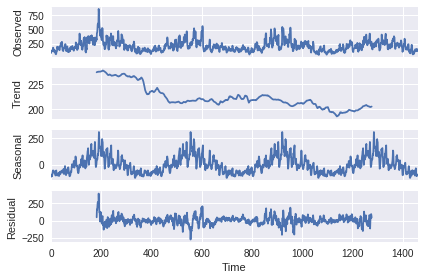

In [353]:
plt.figure(figsize=(14,7))
sm.tsa.seasonal_decompose(np.array(Train.sales), freq=365).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(Train.sales)[1])

Критерий Дики-Фуллера: p=0.000874


<Figure size 1008x504 with 0 Axes>

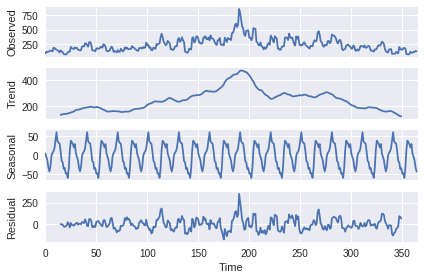

In [354]:
plt.figure(figsize=(14,7))
sm.tsa.seasonal_decompose(np.array(Train.sales[:365]), freq=30).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(Train.sales)[1])

#### Преобразование Бокса-Кокса для стабилизации дисперсии (логарифмирование)

In [355]:
Image("Преобразование Бокса - Кокса.png", width=750, height=750)

Оптимальный параметр преобразования Бокса-Кокса: -0.020020
Критерий Дики-Фуллера: p=0.004674


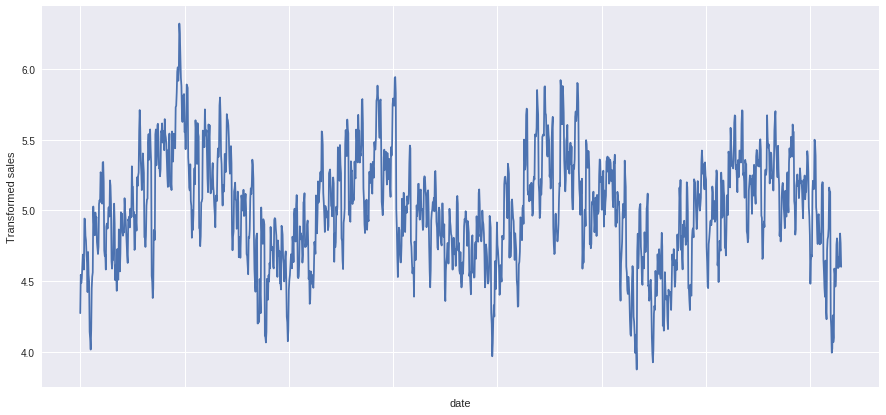

In [356]:
Train['sales_box'], lmbda = stats.boxcox(Train.sales)
plt.figure(figsize=(15,7))
Train.sales_box.plot()
plt.ylabel('Transformed sales')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(Train.sales_box)[1])

Попробуем сезонное дифференцирование; сделаем на продифференцированном ряде STL-декомпозицию и проверим стационарность.

Критерий Дики-Фуллера: p=0.000000


<Figure size 1080x504 with 0 Axes>

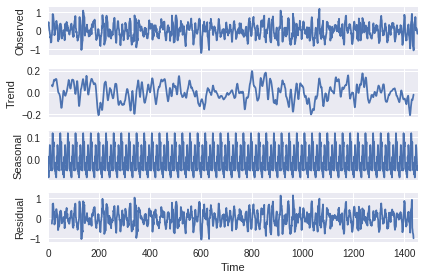

In [357]:
Train['sales_box_diff'] = Train.sales_box - Train.sales_box.shift(7)
plt.figure(figsize=(15,7))
sm.tsa.seasonal_decompose(np.array(Train.sales_box_diff[7:]), freq=30).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(Train.sales_box_diff[7:])[1])

### Подбор модели

Посмотрим на ACF и PACF полученного ряда:

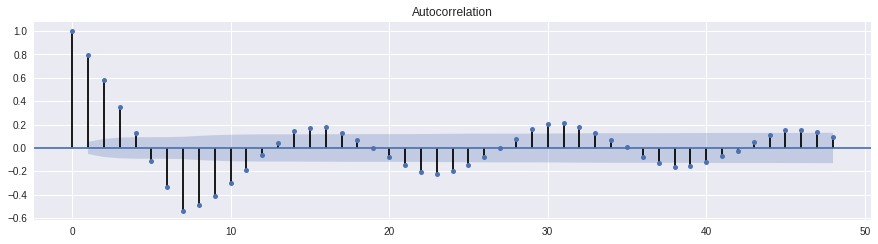

In [358]:
plt.figure(figsize=(15,8))
ax = plt.subplot(2, 1, 1)
sm.graphics.tsa.plot_acf(Train.sales_box_diff[7:].values.squeeze(), lags=48, ax=ax)
plt.show()

In [0]:
ps = range(10, 25)
d=1
qs = range(1, 2)
Ps = range(1, 2)
D=1
Qs = range(1, 2)

In [360]:
from itertools import product
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

15

In [361]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(Train.sales_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

CPU times: user 30min 5s, sys: 18min 10s, total: 48min 16s
Wall time: 24min 21s


In [362]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

       parameters          aic
13  (23, 1, 1, 1) -1178.225986
14  (24, 1, 1, 1) -1175.697057
12  (22, 1, 1, 1) -1133.542377
11  (21, 1, 1, 1) -1113.580508
10  (20, 1, 1, 1) -1066.136624


In [363]:
print(best_model.summary())

                                  Statespace Model Results                                 
Dep. Variable:                           sales_box   No. Observations:                 1460
Model:             SARIMAX(23, 1, 1)x(1, 1, 1, 12)   Log Likelihood                 616.113
Date:                             Tue, 16 Apr 2019   AIC                          -1178.226
Time:                                     08:43:34   BIC                          -1035.499
Sample:                                 01-01-2014   HQIC                         -1124.983
                                      - 12-30-2017                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5688      0.072      7.934      0.000       0.428       0.709
ar.L2         -0.0019      

Критерий Стьюдента: p=0.258942
Критерий Дики-Фуллера: p=0.000000


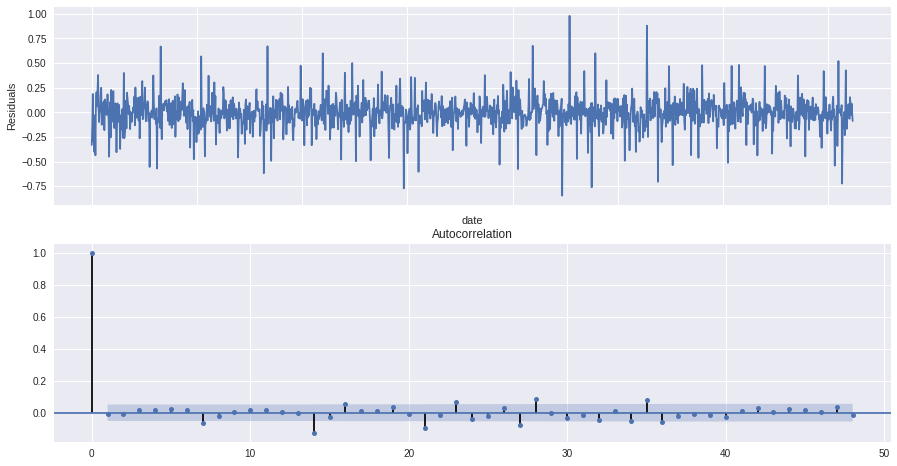

In [364]:
plt.figure(figsize=(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Посмотрим, насколько хорошо модель описывает данные:

In [0]:
def invboxcox(y,lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

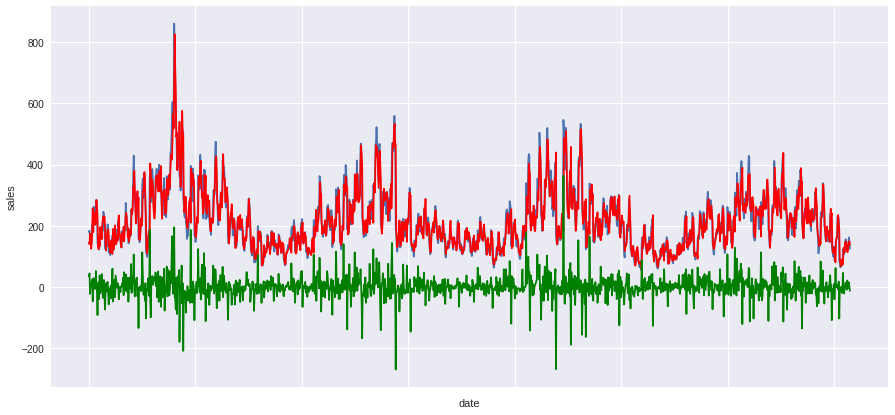

In [370]:
Train['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize=(15,7))
Train.sales[30:].plot()
Train.model[30:].plot(color='r')
(Train.sales[30:] - Train.model[30:]).plot(color='g')
plt.ylabel('sales')
plt.show()

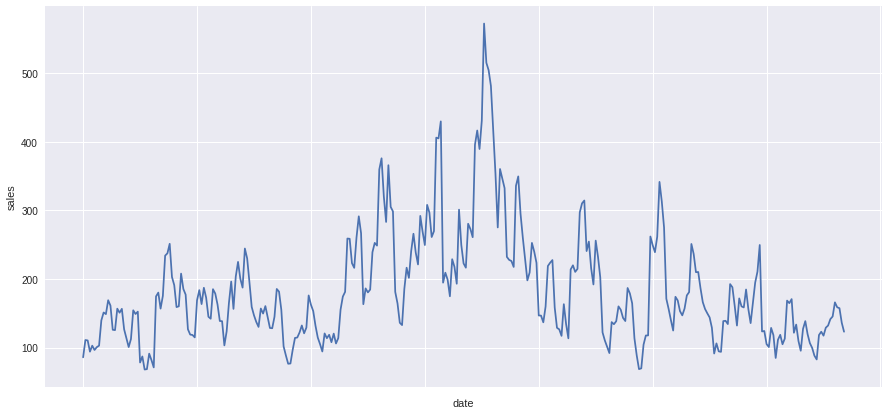

In [379]:
Test['model'] = invboxcox(best_model.predict(start=1460, end=(1461+364)), lmbda)
plt.figure(figsize=(15,7))
Test.sales[30:].plot()
Test.model[30:].plot(color='r')
plt.ylabel('sales')
plt.show()

## Домашнее задание

1. Реализовать метод Prophet для представленных данных. Получить прогноз. Оценить точность.
2. Реализовать метод "Дерево регрессии". Получить прогноз. Оценить точность.
3. Изучить выше представленные методы. Попытаться улучшить прогноз с помощью генерации новых признаков, учета нелинейных зависимостей в признаках, подбора оптимальных гиперпараметров или другими методами.

###Prophet

In [498]:
from fbprophet import Prophet
df.head()

,date,price,T,sales,dw,month,year,day_off,warm
0,2014-01-01,126.9,-27,87.110569,3,1,2014,0,NaN
1,2014-01-02,126.9,-25,117.233120,4,1,2014,0,NaN
2,2014-01-03,126.9,-20,109.978085,5,1,2014,0,NaN
3,2014-01-04,126.9,-21,114.134202,6,1,2014,1,NaN
4,2014-01-05,115.9,-24,125.839838,7,1,2014,1,NaN


In [0]:
df_pr = df.rename(columns = {'date': 'ds', 'sales': 'y'})

df_pr_train = df_pr_train[:-30]
df_pr_test = df_pr_train[-30:]

In [0]:
def outliers_to_na(ts, devs):
    median= ts['y'].median()
    std = np.std(ts['y'])
    for x in range(len(ts)):
        val = ts['y'][x]
        if (val < median - devs * std or val > median + devs * std):
            ts['y'][x] = None 
    return ts

In [501]:
df_pr = outliers_to_na(df_pr, 2)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [0]:
def quality_control(model, forecast):
    model.plot(forecast)
    model.plot_components(forecast)
    
    cmp_df = forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(df_pr.set_index('ds'))
    
    cmp_df['e'] = cmp_df['y'] - cmp_df['yhat']

    print('MAE = ', np.mean(abs(cmp_df[-predictions:]['e'])))
    return cmp_df

In [399]:
m = Prophet(interval_width=0.95)
m.fit(df_pr_train)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Среднее абсолютное отклонение на обучающей выборке: 24.7
Среднее абсолютное отклонение на тестовой выборке: 34.48
MAE =  42.12115559424779


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,...,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,y,abs_deviation
0,2014-01-01,234.330566,-5.959814,254.393549,234.330566,234.330566,-111.890270,-111.890270,-111.890270,-29.644355,...,-29.644355,-82.245915,-82.245915,-82.245915,0.0,0.0,0.0,122.440296,87.110569,40.557337
1,2014-01-02,234.351435,48.026513,312.584728,234.351435,234.351435,-51.545361,-51.545361,-51.545361,30.326886,...,30.326886,-81.872247,-81.872247,-81.872247,0.0,0.0,0.0,182.806074,117.233120,55.933813
2,2014-01-03,234.372304,52.132716,305.528858,234.372304,234.372304,-55.790340,-55.790340,-55.790340,25.581466,...,25.581466,-81.371805,-81.371805,-81.371805,0.0,0.0,0.0,178.581965,109.978085,62.379591


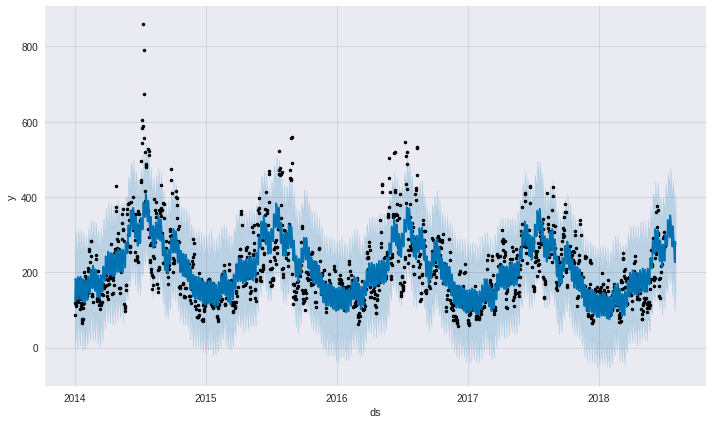

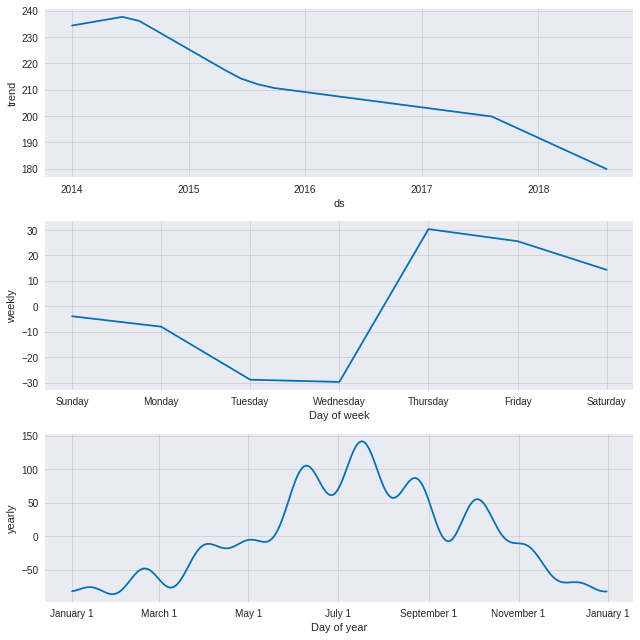

In [400]:

future = m.make_future_dataframe(periods=30)
forecast = m.predict(future)
forecast['y'] = df_pr['y']

forecast['abs_deviation'] = abs((100 * (forecast['y'] - forecast['yhat']) / forecast['y']))


print('Среднее абсолютное отклонение на обучающей выборке: {}'.format(round(np.mean(forecast[:-30]['abs_deviation']), 2)))
print('Среднее абсолютное отклонение на тестовой выборке: {}'.format(round(np.mean(forecast[-30:]['abs_deviation']), 2)))
quality_control(m,forecast)

forecast.head(3)

### Дерево регрессии



In [401]:
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(random_state=0)
regressor.fit(X_train,Y_train)
regressor_train = regressor.predict(X_train)
regressor_test = regressor.predict(X_test)

print('Среднее абсолютное отклонение на обучающем наборе: ', np.round(mean_absolute_error(Y_train[30:], regressor_train[30:]), 2))
print('Среднее абсолютное отклонение на тестовом наборе: ', np.round(mean_absolute_error(Y_test[30:], regressor_test[30:]), 2))

Среднее абсолютное отклонение на обучающем наборе:  9.64
Среднее абсолютное отклонение на тестовом наборе:  29.27


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


###Подбираем гиперпараметры

In [402]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    "n_estimators": [50, 100, 200],
    "min_samples_split": [2, 3, 4, 5],
    "max_depth": [5,10,20],
    "min_samples_leaf": [3,4,5],
    "max_leaf_nodes": [200,300,400]
    
    
}
GS = GridSearchCV(regressor, param_grid, cv=10)
GS.fit(X_train,Y_train)
GS_train = GS.predict(X_train)
GS_test= GS.predict(X_test)

print('Среднее абсолютное отклонение на обучающем наборе: ', np.round(mean_absolute_error(Y_train[30:], GS_train[30:]), 2))
print('Среднее абсолютное отклонение на тестовом наборе: ', np.round(mean_absolute_error(Y_test[30:], GS_test[30:]), 2))


GS.best_params_

Среднее абсолютное отклонение на обучающем наборе:  15.45
Среднее абсолютное отклонение на тестовом наборе:  28.33


{'max_depth': 20,
 'max_leaf_nodes': 300,
 'min_samples_leaf': 3,
 'min_samples_split': 2,
 'n_estimators': 50}

In [433]:

from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor( n_estimators = 50, min_samples_split = 2,
                                  max_depth = 20,criterion = "mae", min_samples_leaf = 3 , max_leaf_nodes  = 300)
regressor.fit(X_train,Y_train)
regressor_train = regressor.predict(X_train)
regressor_test = regressor.predict(X_test)

print('Среднее абсолютное отклонение на обучающем наборе: ', np.round(mean_absolute_error(Y_train[30:], regressor_train[30:]), 2))
print('Среднее абсолютное отклонение на тестовом наборе: ', np.round(mean_absolute_error(Y_test[30:], regressor_test[30:]), 2))

Среднее абсолютное отклонение на обучающем наборе:  16.34
Среднее абсолютное отклонение на тестовом наборе:  27.64


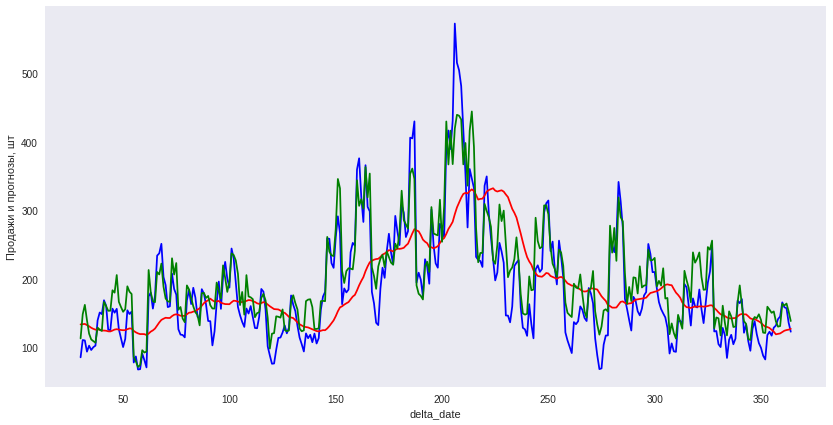

In [404]:
plt.figure(figsize=(14,7))
x=range(len(Y_test))
plt.plot(x[30:], Y_test[30:], 'b')
plt.plot(x[30:], Y_mean[30:], 'r')
plt.plot(x[30:], regressor_test[30:], 'g')
plt.xlabel('delta_date')
plt.ylabel('Продажи и прогнозы, шт')
plt.grid()

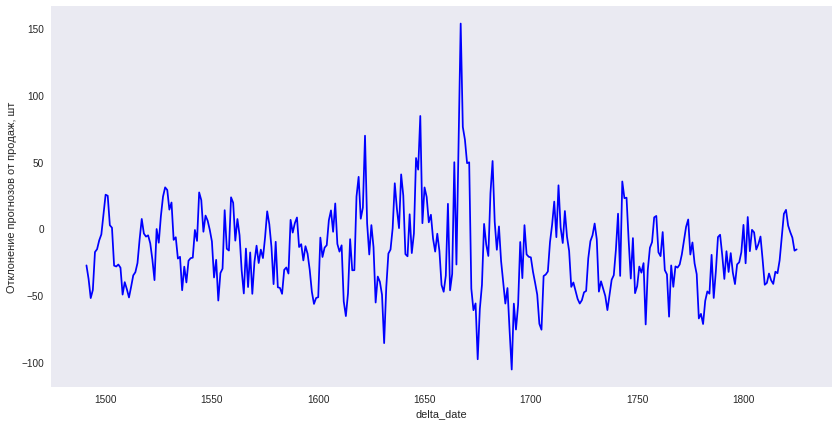

In [405]:
# Отклонение прогноза от факта

plt.figure(figsize=(14,7))
plt.plot(Y_test[30:] - regressor_test[30:], 'b')
plt.xlabel('delta_date')
plt.ylabel('Отклонение прогнозов от продаж, шт')
plt.grid()

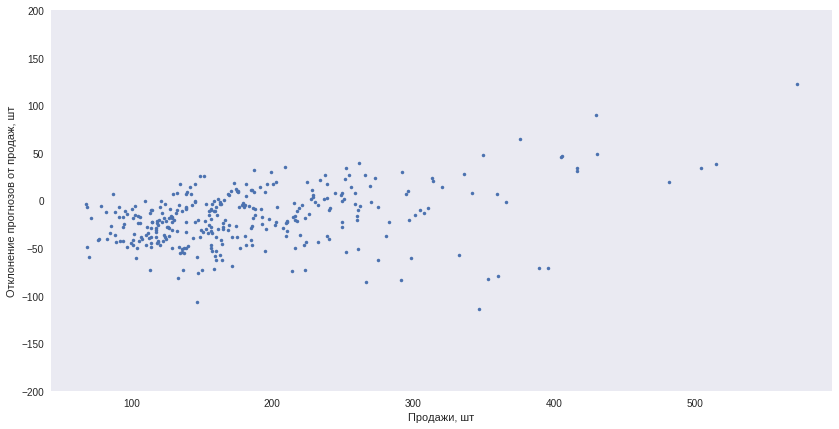

In [434]:
# График остатков

plt.figure(figsize=(14,7))
plt.plot(Y_test[30:], Y_test[30:] - regressor_test[30:], '.')
plt.ylim([-200, 200])
plt.xlabel('Продажи, шт')
plt.ylabel('Отклонение прогнозов от продаж, шт')
plt.grid()

###Добавим новые признаки

In [0]:
df['dw']=pd.DatetimeIndex(df.date).weekday+1
df['month']=pd.DatetimeIndex(df.date).month
df['year']=pd.DatetimeIndex(df.date).year
df['day_off'] = df_pr_train['ds'].apply(day_off)

In [0]:
def day_off(ds):
  today = pd.to_datetime(ds)
  if today.weekday() == 5 or today.weekday() == 6:
    return 1
  else:
    return 0

MAE =  38.95001687363192


,yhat,yhat_lower,yhat_upper,price,T,y,dw,month,year,day_off,warm,e
ds,,,,,,,,,,,,
2014-01-01,133.164590,74.217159,198.569060,126.9,-27.0,87.110569,3.0,1.0,2014.0,0.0,NaN,-46.054021
2014-01-02,177.836793,116.609055,239.881665,126.9,-25.0,117.233120,4.0,1.0,2014.0,0.0,NaN,-60.603673
2014-01-03,175.069239,112.411488,242.443419,126.9,-20.0,109.978085,5.0,1.0,2014.0,0.0,NaN,-65.091154
2014-01-04,165.434849,98.216012,224.703185,126.9,-21.0,114.134202,6.0,1.0,2014.0,1.0,NaN,-51.300646
2014-01-05,154.247556,89.192348,213.274702,115.9,-24.0,125.839838,7.0,1.0,2014.0,1.0,NaN,-28.407719
2014-01-06,151.180336,87.411585,212.009777,115.9,-21.0,137.261317,1.0,1.0,2014.0,0.0,NaN,-13.919019
2014-01-07,132.158021,72.360757,191.137323,115.9,-20.0,130.377506,2.0,1.0,2014.0,0.0,NaN,-1.780515
2014-01-08,131.039981,66.326164,198.825025,115.9,-27.0,122.157261,3.0,1.0,2014.0,0.0,NaN,-8.882720
2014-01-09,175.568967,113.114584,239.104437,115.9,-23.0,181.981721,4.0,1.0,2014.0,0.0,NaN,6.412754


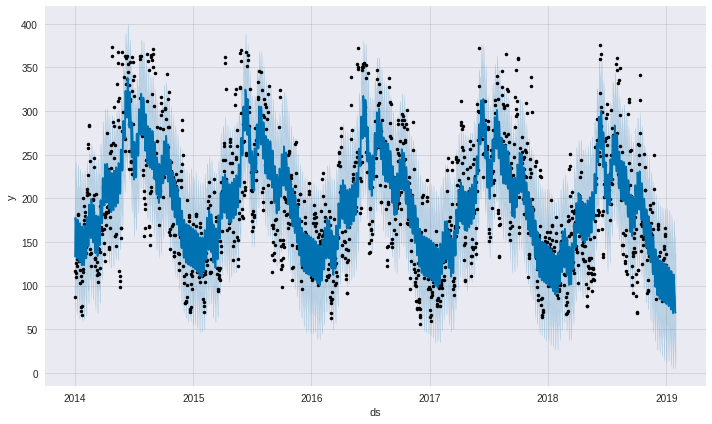

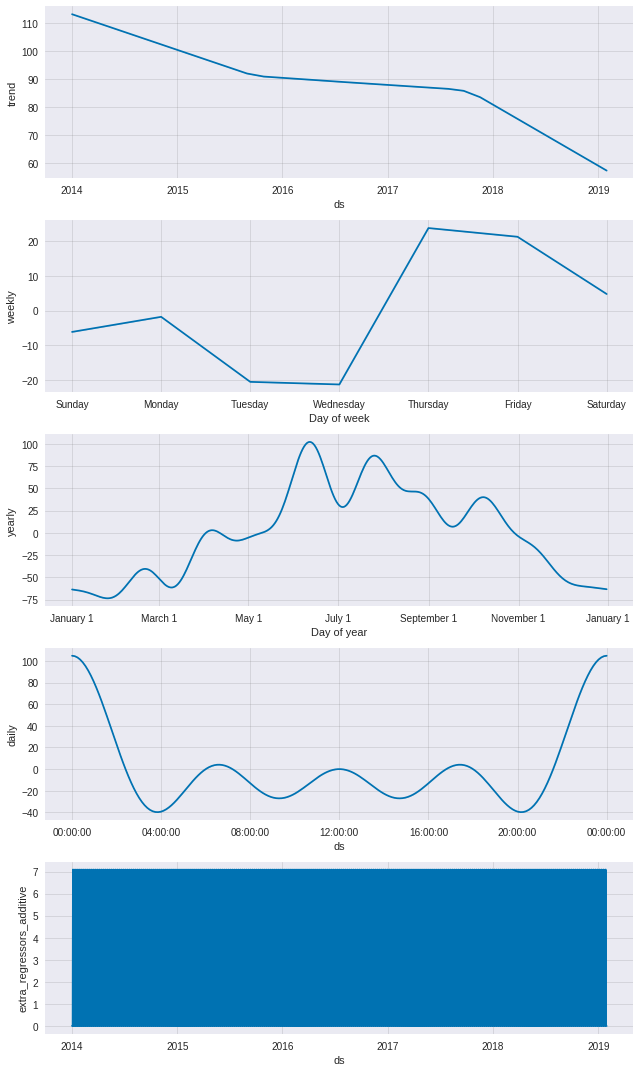

In [598]:
m = Prophet(daily_seasonality=True)
m.add_regressor('day_off') 
m.fit(df_pr)

future = m.make_future_dataframe()
future['day_off'] = future3['ds'].apply(day_off)
forecast = m3.predict(future3)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

quality_control(m3, forecast3)



С добавлением выходных получилось достигнуть лучшего результата